# ADANNs for the semilinear PDEs
Adjusted from ADANN_SG.ipynb from first version of ADANN project.

# Setup

We consider the semilinear heat PDE d dimensions:
$$
    \partial_t u (t, x)
=
    \nu (\Delta_{x} u)(t, x) + f(u(t, x)),
$$
for $(t, x) \in [0,T] \times [0, S]^d$ with perdiodic boundary conditions.

We want to approximate the map
$$
\Phi(u(0, \cdot)) = u(T, \cdot).
$$

Problem parameters:  $T, S, \nu \in (0,\infty)$, $f \colon \mathbb{R} \to \mathbb{R}$, and distribution of initial value.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
import os
import shutil
import importlib
import time 
import seaborn as sns
sns.set_style("white")

sys.path.insert(1, '../1_Modules')

# Importing the modules
import random_function_generators
import ode_methods
import training
import training_samples_generators
import operator_learning_models
import utils
import semilinear_heat_multi_d_classical_methods
import evaluation_utils
import documentation_utils
import PDE_operations

sys.path.insert(1, '1_ADANN_Modules')

import ADANNs
import ADANNs_training
import ADANNs_grid
import ADANNs_opt

In [2]:
# Reloading the modules
importlib.reload(random_function_generators)
importlib.reload(ode_methods)
importlib.reload(utils)
importlib.reload(training)
importlib.reload(training_samples_generators)
importlib.reload(operator_learning_models)
importlib.reload(semilinear_heat_multi_d_classical_methods)
importlib.reload(evaluation_utils)
importlib.reload(documentation_utils)
importlib.reload(PDE_operations)
importlib.reload(ADANNs)
importlib.reload(ADANNs_training)
importlib.reload(ADANNs_grid)
importlib.reload(ADANNs_opt)


from random_function_generators import *
from ode_methods import *
from training import *
from training_samples_generators import *
from operator_learning_models import *
from utils import *
from semilinear_heat_multi_d_classical_methods import *
from evaluation_utils import *
from documentation_utils import *
from PDE_operations import *
from ADANNs import *
from ADANNs_training import *
from ADANNs_grid import *
from ADANNs_opt import *

### Setup

In [11]:
test_run = True

# Problem setup for periodic semilinear PDE
###################################################
T = 2.
space_size = 1.
laplace_factor = 0.01
dim = 1
nonlin = lambda x : torch.sin(np.pi * x)
nonlin_name = "Sine"
# nonlin = lambda x : (1-x) / (1 + x**2)
# nonlin_name = "Fraction"

# initial value
var = 10**5
decay_rate = 2
offset = np.power(var, 1/decay_rate)
inner_decay = 1.

In [12]:
initial_value_generator = RandnFourierSeriesGenerator([var, decay_rate, offset, inner_decay, space_size, dim])
#Discretization operations
x_values = x_values_periodic
reduce_dimension = lambda values, space_resolution_step: reduce_dimension_periodic(values, space_resolution_step, dim=dim)
get_higher_nr_spacediscr = get_higher_nr_spacediscr_periodic
create_boundary_values = create_boundary_values_periodic

In [13]:
# Name of the problem
pde_name = f"Semilinear_heat_{dim}-dimensional_T_{T}_space_size_{space_size}_laplace_factor_{laplace_factor}_nonlin_{nonlin_name}_var_{var}_decay_rate_{decay_rate}_offset_{offset}_inner_decay_{inner_decay}"

#Create folder for all outputs
# output_folder_dir = create_output_folder(pde_name)
# output_folder_dir = "Z Outputs/ADANNs (Server) - Full experiments/Z Outputs/ZZ 2024-04-18 07h53m07s Semilinear_heat_1-dimensional_T_2.0_space_size_1.0_laplace_factor_0.01_nonlin_Sine_var_100000_decay_rate_2_offset_316.22776601683796_inner_decay_1.0/"
output_folder_dir = "Z Outputs/ADANNs (Server) - Full experiments/Z Outputs/ZZ 2024-04-19 05h32m34s Semilinear_heat_2-dimensional_T_2.0_space_size_1.0_laplace_factor_0.01_nonlin_Sine_var_100000_decay_rate_2_offset_316.22776601683796_inner_decay_1.0/"

# Prepare df to store data
methods_data = pd.DataFrame(columns=["nr_params", "training_time", "test_time", "L2_error", "done_trainsteps", "learning_rate_history", "batch_size_history"])
methods = {}

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

### Create Train and Test sets

In [14]:
generate_data = True 
data_load_folder = f"Z Outputs/ZZ 2023-11-21 08h55m16s {pde_name}/"

#Nr of input points allowed to be used by methods
nr_spacediscr = 16 if test_run else (64 if dim==1 else 32)

#Method for reference solutions for training of models
reference_algorithm = lambda initial_values, nr_timesteps: periodic_semilinear_pde_spectral_lirk(initial_values, T, laplace_factor, nonlin, space_size, nr_timesteps, dim=dim)

# Train set parameters
train_space_resolution_step = 2 if test_run else (4 if dim==1 else 2)
train_nr_timesteps = 20 if test_run else 1000
nr_train_samples = 2**10 if test_run else (2**18 if dim==1 else 2**16)
nr_validation_samples = 2**10 if test_run else (2**14 if dim==1 else 2**11)

test_space_resolution_step = 2 if test_run else (8 if dim==1 else 4)
test_nr_timesteps = 50 if test_run else 1500
nr_test_samples = 2**10 if test_run else (2**14 if dim==1 else 2**11)

only_save_rough = True

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

parameters = {
    'T': T,
    'space_size': space_size,
    'laplace_factor': laplace_factor,
    'var': var,
    'dim': dim,
    'decay_rate': decay_rate,
    'offset': offset,
    'inner_decay': inner_decay,
    'nr_spacediscr': nr_spacediscr,
    'train_space_resolution_step': train_space_resolution_step,
    'train_nr_timesteps': train_nr_timesteps,
    'nr_train_samples': nr_train_samples,
    'nr_validation_samples': nr_validation_samples,
    'test_space_resolution_step': test_space_resolution_step,
    'nr_test_samples': nr_test_samples,
    'test_nr_timesteps': test_nr_timesteps,
    'reference_algorithm': reference_algorithm.__name__,
    'only_save_rough': only_save_rough
}

# save parametesr
with open(output_folder_dir + 'train_test_parameters.json', 'w') as fp:
    json.dump(parameters, fp)

In [35]:
# Produce train and test data
train_nr_spacediscr = get_higher_nr_spacediscr(nr_spacediscr, train_space_resolution_step)
test_nr_spacediscr = get_higher_nr_spacediscr(nr_spacediscr, test_space_resolution_step)

print("Generating train samples")
train_initial_values_fine, train_ref_sol_fine, train_initial_values_rough, train_ref_sol_rough = (
    get_data(
        initial_value_generator, reference_algorithm, 
        nr_train_samples, train_nr_spacediscr, train_nr_timesteps, 
        reduce_dimension, train_space_resolution_step, 'train', 
        output_folder_dir, generate_data, data_load_folder, parameters, only_save_rough
    ))
training_samples_generator = TrainingSamplesGeneratorFromSolutions(train_initial_values_rough, train_ref_sol_rough)

print("Generating validation samples")
validation_initial_values_fine, validation_ref_sol_fine, validation_initial_values_rough, validation_ref_sol_rough = (
    get_data(
        initial_value_generator, reference_algorithm, 
        nr_validation_samples, test_nr_spacediscr, test_nr_timesteps, 
        reduce_dimension, test_space_resolution_step, 'validate', 
        output_folder_dir, generate_data, data_load_folder, parameters, only_save_rough
    ))

print("Generating test samples")
test_initial_values_fine, test_ref_sol_fine, test_initial_values_rough, test_ref_sol_rough = (
    get_data(
        initial_value_generator, reference_algorithm, 
        nr_test_samples, test_nr_spacediscr, test_nr_timesteps, 
        reduce_dimension, test_space_resolution_step, 'test', 
        output_folder_dir, generate_data, data_load_folder, parameters, only_save_rough
    ))

Generating train samples
IV is generated
Computation time:  0.02585787998395972
Generating validation samples
IV is generated
Computation time:  0.054615100991213694
Generating test samples
IV is generated
Computation time:  0.052706339018186554


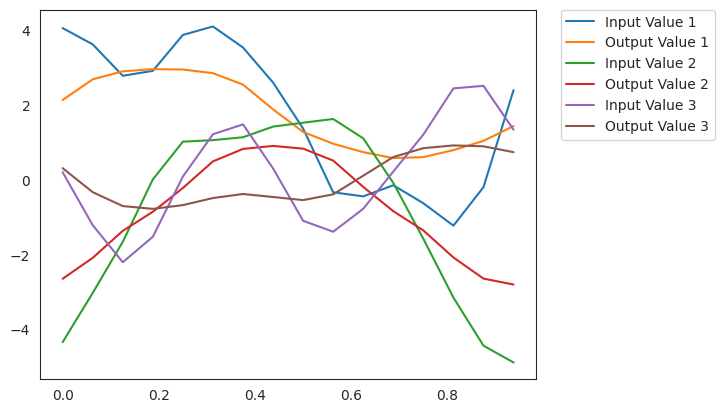

In [36]:
# Plot some reference solutions
plot_reference_solutions(train_initial_values_rough, train_ref_sol_rough, 3, dim, x_values, space_size, pde_name, output_folder_dir)

# Create models and methods to be tested

In [37]:
# Optimizer
optimizer_class = torch.optim.Adam
# Loss function
loss_fn = torch.nn.MSELoss()

## Create and train ADANNs

In [15]:
# Training hyperparams

################
# BASE
base_training_kwargs = {
    "max_trainsteps": 1 if test_run else 100000,
    "initial_batchsize": 2**8 if dim==1 else 2**7,
    "max_batchsize": 2**8 if dim==1 else 2**7,
    "output_steps": 400 if test_run else 400,
    "eval_steps": 400 if test_run else 400,
    "improvement_tolerance": 0.96 if test_run else 0.96,
    "initial_lr": None if test_run else None
}

# Learning rate parameters
local_learning_rates = True
base_lr_test_trainsteps = 1 if test_run else 50
base_smallest_power = -20
base_largest_power = 5.
base_maxiter = 1 if test_run else 15
base_lr_search_parameters = [base_lr_test_trainsteps, base_smallest_power, base_largest_power, base_maxiter]



################
# DIFF
only_train_base = True

diff_training_kwargs = {
    "max_trainsteps": 0 if test_run else 100000,
    "initial_batchsize": base_training_kwargs["initial_batchsize"],
    "max_batchsize": base_training_kwargs["initial_batchsize"],
    "output_steps": 100 if test_run else 200,
    "eval_steps": 100 if test_run else 100,
    "improvement_tolerance": 0.96 if test_run else 0.96,
    "initial_lr": None if test_run else 0.001
}

# Learning rate parameters
diff_lr_test_trainsteps = 1 if test_run else 100
diff_smallest_power = -10
diff_largest_power = 0.
diff_maxiter = 1 if test_run else 15
diff_lr_search_parameters = [diff_lr_test_trainsteps, diff_smallest_power, diff_largest_power, diff_maxiter]


# ADANNs Settings
ADANN_base_model_class = SecondOrderLirkFDMPeriodicSemilinearPDEAdannBasemodel
base_model_kwargs = {"T": T, 
                     "laplace_factor": laplace_factor, 
                     "nonlin": nonlin, 
                     "space_size": space_size, 
                     "nr_spacediscr": nr_spacediscr, 
                     "nonlin_name": nonlin_name, 
                     "dim": dim
                     }

diff_model_class = ANNModel 
diff_model_params = [[nr_spacediscr, 200, 500, 500, 200, nr_spacediscr]] if dim==1 else [[nr_spacediscr**dim, 2**11, 2**12, 2**11, nr_spacediscr**dim]]

#### ADANN Experiment 1: Grid based approach

In [39]:
#Grid
grid_p1_low = 0.1
grid_p1_high = 1.2
grid_nr_p1_steps = 2 if test_run else (5 if dim==1 else 5)

grid_p2_low = 0.2 if test_run else (0.25 if dim==1 else 0.1)
grid_p2_high = 1.2
grid_nr_p2_steps = 2 if test_run else (5 if dim==1 else 5)

param_grid_parameters = [grid_p1_low, grid_p1_high, grid_nr_p1_steps, grid_p2_low, grid_p2_high, grid_nr_p2_steps]

list_base_nr_timesteps_grid = [2, 4, 8] if test_run else ([2, 4, 8] if dim ==1 else [2, 4, 8])

------------------------------------------------------------

------------------------------------------------------------

Base nr timesteps: 2
------------------------------------------------------------

------------------------------------------------------------

--------------------------------------RUN (0,0) : [0.4666666666666667, 0.5333333333333333]--------------------------------------
Start error: 0.2595216566284412
------ TRAINING BASE------
------ SEARCHING OPTIMAL LEARNING RATE FOR base_2_tsteps_grid_0-0 ------
Evaluating at -0.9016994374947425
Best learning rate for base_2_tsteps_grid_0-0: 0.0018818072639922873
    Initial batch size:  256
    Initial learning rate:  0.0018818072639922873
0 (validation loss) : 0.0707299262
0 (train loss) : 0.0620821342
End error base: 0.23482736800689388
End error: 0.2348253850044125



 We have a new best base model!
--------------------------------------RUN (1,0) : [0.8333333333333333, 0.5333333333333333]--------------------------------

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

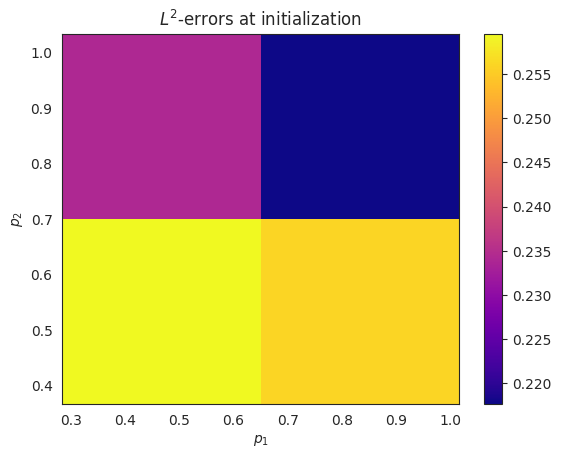

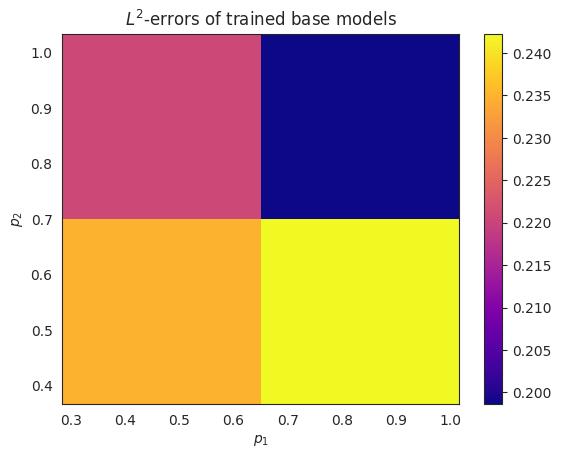

------------------------------------------------------------

------------------------------------------------------------

Base nr timesteps: 4
------------------------------------------------------------

------------------------------------------------------------

--------------------------------------RUN (0,0) : [0.4666666666666667, 0.5333333333333333]--------------------------------------
Start error: 0.09238196648821258
------ TRAINING BASE------
------ SEARCHING OPTIMAL LEARNING RATE FOR base_4_tsteps_grid_0-0 ------
Evaluating at -0.9016994374947425
Best learning rate for base_4_tsteps_grid_0-0: 0.0018818072639922873
    Initial batch size:  256
    Initial learning rate:  0.0018818072639922873
0 (validation loss) : 0.00931614079
0 (train loss) : 0.00777954794
End error base: 0.10068766070494563
End error: 0.10069142985444474



 We have a new best base model!
--------------------------------------RUN (1,0) : [0.8333333333333333, 0.5333333333333333]----------------------------

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

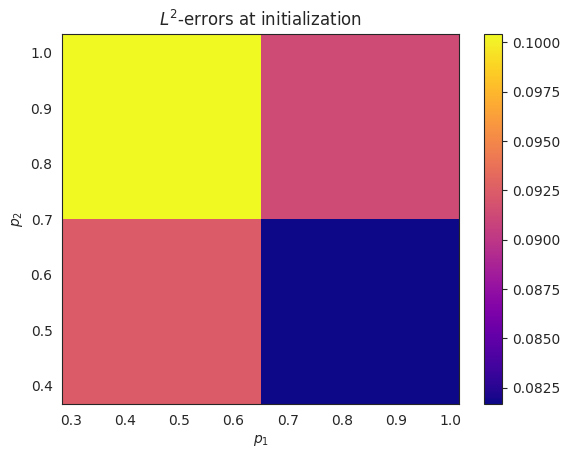

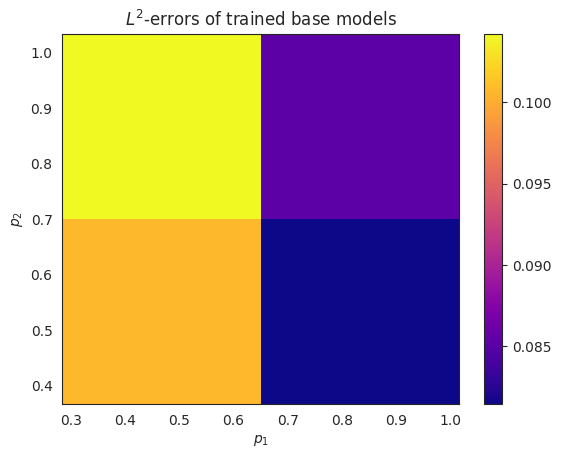

------------------------------------------------------------

------------------------------------------------------------

Base nr timesteps: 8
------------------------------------------------------------

------------------------------------------------------------

--------------------------------------RUN (0,0) : [0.4666666666666667, 0.5333333333333333]--------------------------------------
Start error: 0.06248005347547646
------ TRAINING BASE------
------ SEARCHING OPTIMAL LEARNING RATE FOR base_8_tsteps_grid_0-0 ------
Evaluating at -0.9016994374947425
Best learning rate for base_8_tsteps_grid_0-0: 0.0018818072639922873
    Initial batch size:  256
    Initial learning rate:  0.0018818072639922873
0 (validation loss) : 0.0042337724
0 (train loss) : 0.00286971871
End error base: 0.19765247522300486
End error: 0.19764900721974477



 We have a new best base model!
--------------------------------------RUN (1,0) : [0.8333333333333333, 0.5333333333333333]-----------------------------

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

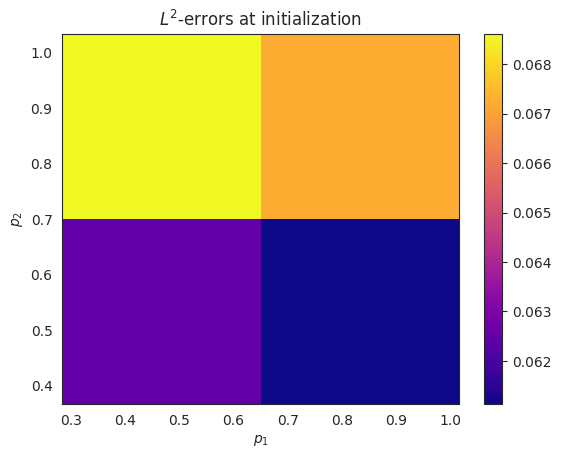

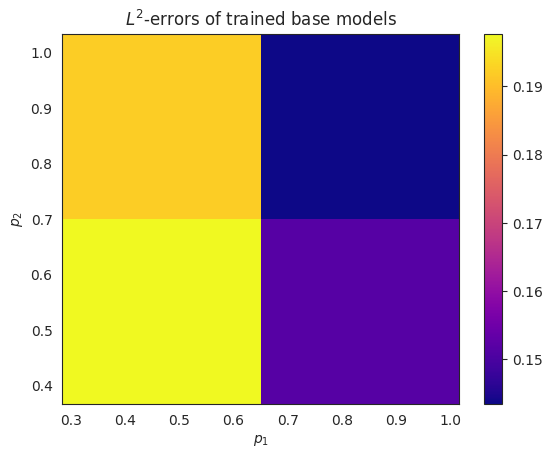

In [40]:
if dim==1:
    adann_grid(
        ADANN_base_model_class=ADANN_base_model_class,
        base_model_kwargs=base_model_kwargs,
        diff_model_class=diff_model_class,
        diff_model_params=diff_model_params,
        list_base_nr_timesteps=list_base_nr_timesteps_grid,
        param_grid_parameters=param_grid_parameters,
        training_samples_generator=training_samples_generator,
        optimizer_class=optimizer_class,
        loss_fn=loss_fn,
        base_training_kwargs=base_training_kwargs,
        base_lr_search_parameters=base_lr_search_parameters,
        diff_training_kwargs=diff_training_kwargs,
        diff_lr_search_parameters=diff_lr_search_parameters,
        output_folder_dir=output_folder_dir,
        methods=methods,
        methods_data=methods_data,
        test_input_values_rough=test_initial_values_rough,
        test_ref_sol_rough=test_ref_sol_rough,
        validation_input_values_rough=validation_initial_values_rough,
        validation_ref_sol_rough=validation_ref_sol_rough,
        pde_name=pde_name,
        space_size=space_size,
        dim=dim,
        only_train_base=only_train_base,
        local_learning_rates=local_learning_rates
    )

/workspace/3_ADANNs/1_ADANN_Modules/ADANNs_grid.py:342: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


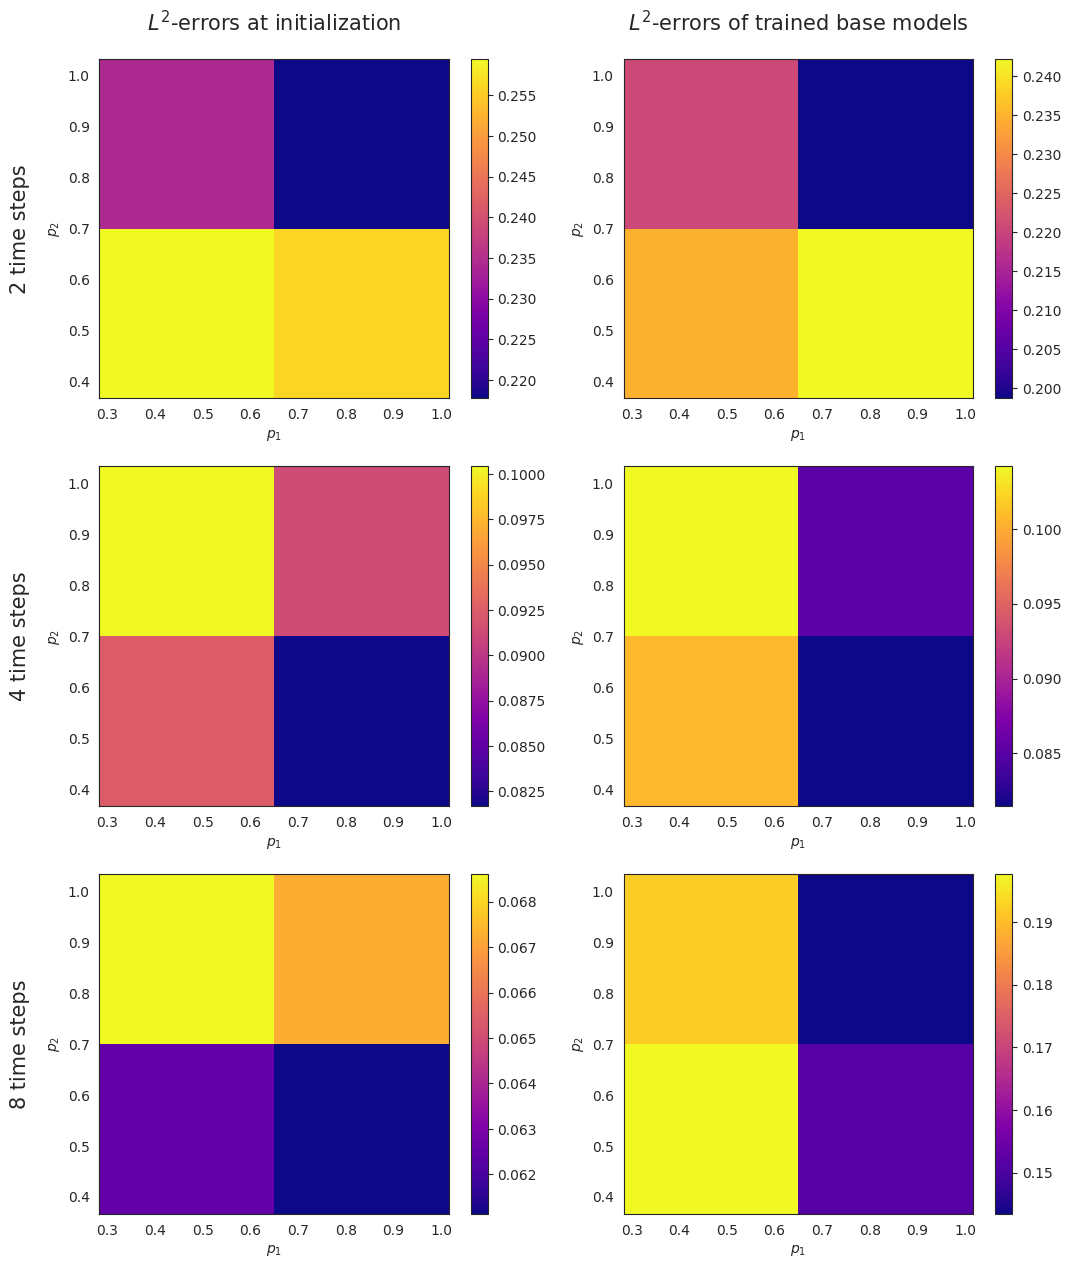

In [41]:
if dim==1:
    plot_error_heat_maps_combined(output_folder_dir, only_train_base, list_base_nr_timesteps_grid, pde_name=pde_name)

#### ADANN Experiment 2: Heuristic approach


In [42]:
p1_low = 0.1 if test_run else 0.1
p1_high = 1.2 if test_run else 1.2
p2_low = 0.25 if test_run else 0.25
p2_high = 1.2 if test_run else 1.2
n_calls = 4 if test_run else 12

p1_low_start = p1_low
p1_high_start = p1_high 
p2_low_start = p2_low 
p2_high_start = p2_high 
n_random_starts = 2 if test_run else 8

opt_params = [p1_low, p1_high, p2_low, p2_high, n_calls, p1_low_start, p1_high_start, p2_low_start, p2_high_start, n_random_starts]

list_base_nr_timesteps_opt = [2, 4, 8] if test_run else ([2, 4, 8] if dim ==1 else [2, 4, 8])

------------------------------------------------------------

------------------------------------------------------------

Base nr timesteps: 2
------------------------------------------------------------

------------------------------------------------------------


------------------------------RUN 0 : [0.15923108430579305, 1.1361483270302415]------------------------------
Start error: 0.3601454892485201
------ TRAINING BASE------
------ SEARCHING OPTIMAL LEARNING RATE FOR base_2_tsteps_opt_nr_0 ------
Evaluating at -0.9016994374947425
Best learning rate for base_2_tsteps_opt_nr_0: 0.0018818072639922873
    Initial batch size:  256
    Initial learning rate:  0.0018818072639922873
0 (validation loss) : 0.116008051
0 (train loss) : 0.139106959
End error base: 0.33124713311664183
End error: 0.32853312315361954
 We have a new best base model!

Summary of model:

------------------------------RUN 1 : [0.8930466903373598, 0.27819940336048604]------------------------------
Start error: 0

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

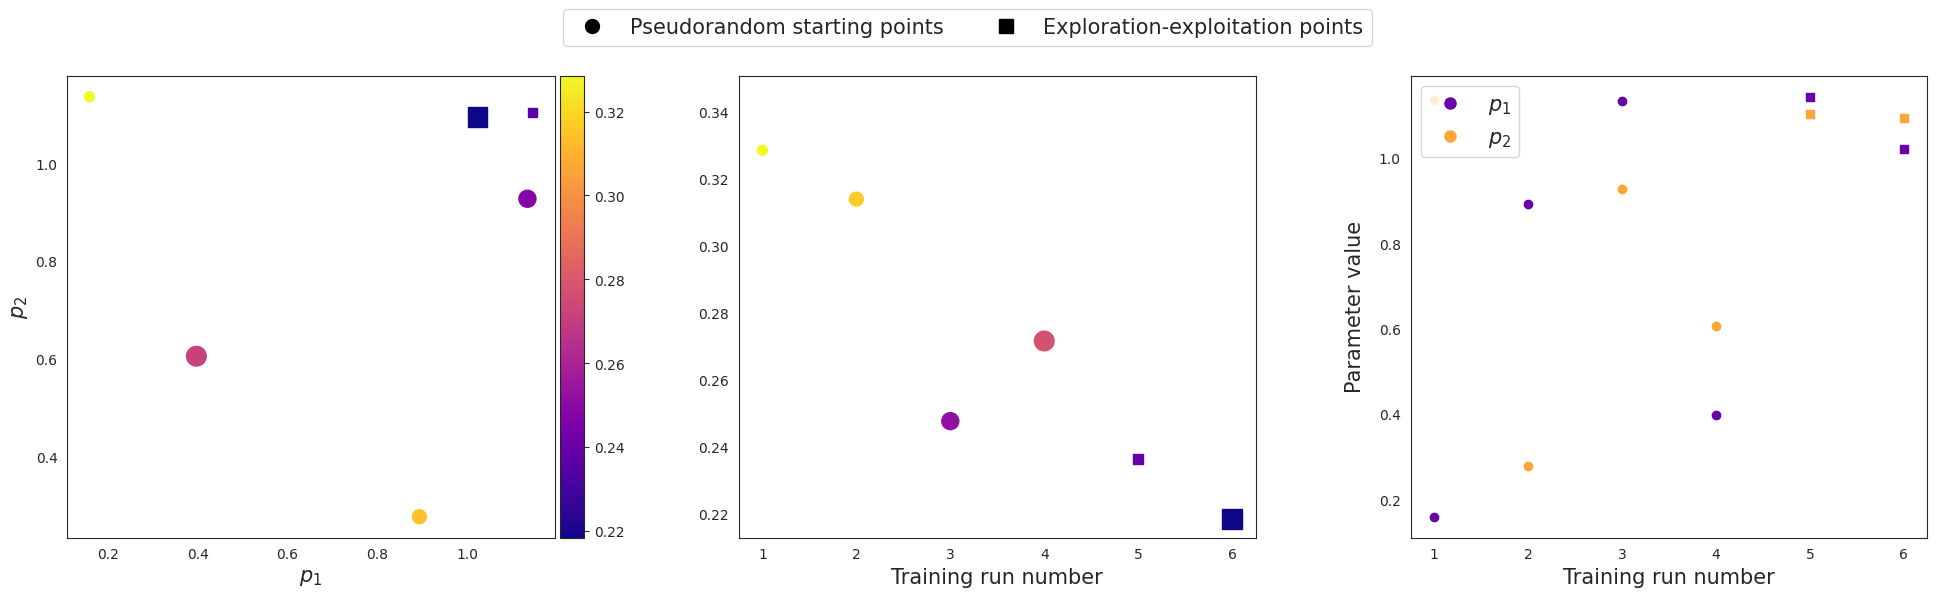

------------------------------------------------------------

------------------------------------------------------------

Base nr timesteps: 4
------------------------------------------------------------

------------------------------------------------------------


------------------------------RUN 0 : [0.5973699893802404, 0.5254276278428733]------------------------------
Start error: 0.08578015140879186
------ TRAINING BASE------
------ SEARCHING OPTIMAL LEARNING RATE FOR base_4_tsteps_opt_nr_0 ------
Evaluating at -0.9016994374947425
Best learning rate for base_4_tsteps_opt_nr_0: 0.0018818072639922873
    Initial batch size:  256
    Initial learning rate:  0.0018818072639922873
0 (validation loss) : 0.00814007688
0 (train loss) : 0.00765865436
End error base: 0.08613953899319636
End error: 0.08408406351537702
 We have a new best base model!

Summary of model:

------------------------------RUN 1 : [0.9384725102223455, 1.1299875741358845]------------------------------
Start error

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

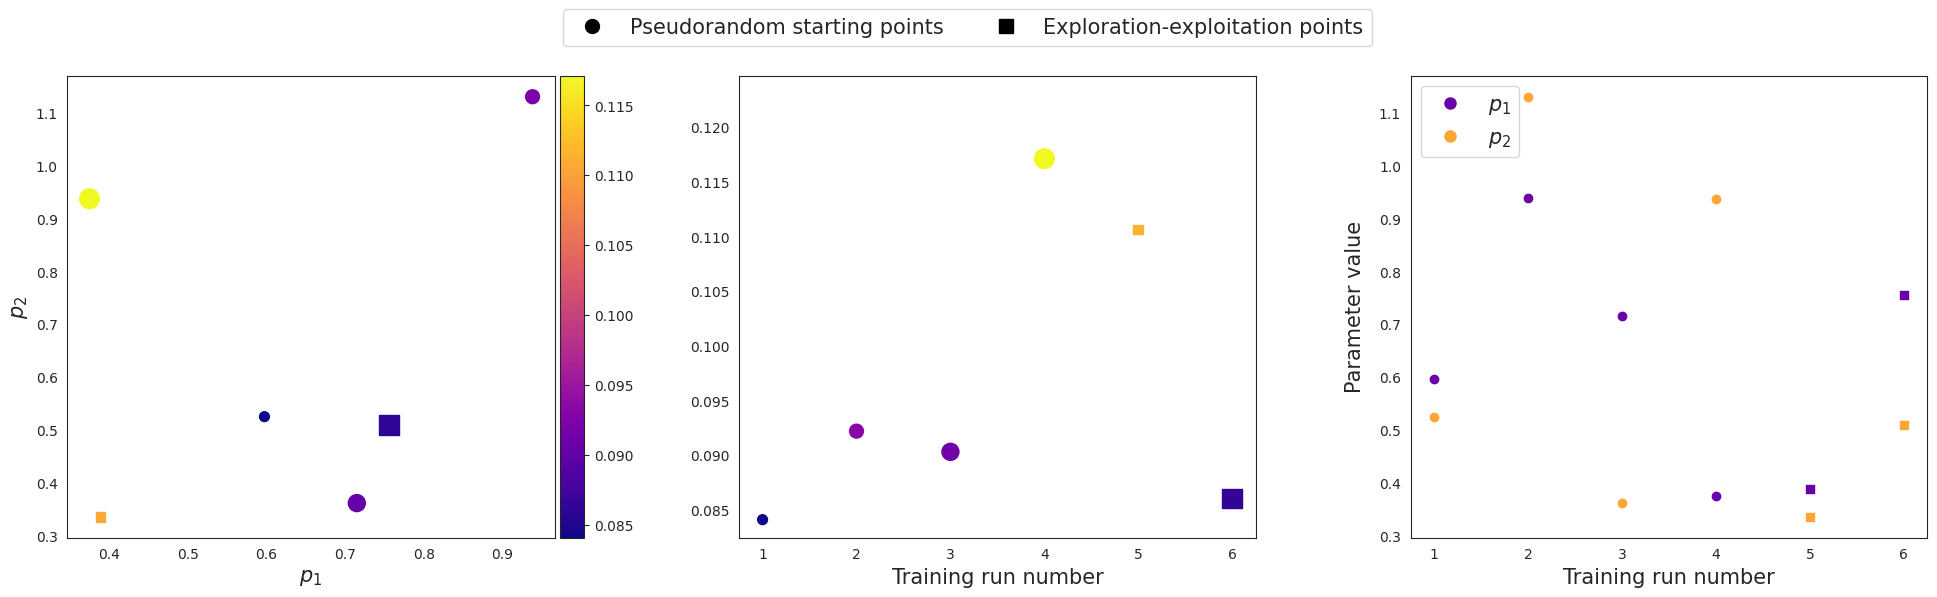

------------------------------------------------------------

------------------------------------------------------------

Base nr timesteps: 8
------------------------------------------------------------

------------------------------------------------------------


------------------------------RUN 0 : [0.2794392333365977, 0.8115334608592093]------------------------------
Start error: 0.06817173750660452
------ TRAINING BASE------
------ SEARCHING OPTIMAL LEARNING RATE FOR base_8_tsteps_opt_nr_0 ------
Evaluating at -0.9016994374947425
Best learning rate for base_8_tsteps_opt_nr_0: 0.0018818072639922873
    Initial batch size:  256
    Initial learning rate:  0.0018818072639922873
0 (validation loss) : 0.00521725975
0 (train loss) : 0.00429251045
End error base: 0.23612982729909326
End error: 0.23746845889208562
 We have a new best base model!

Summary of model:

------------------------------RUN 1 : [0.9067316899076103, 0.5565726862289011]------------------------------
Start error

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

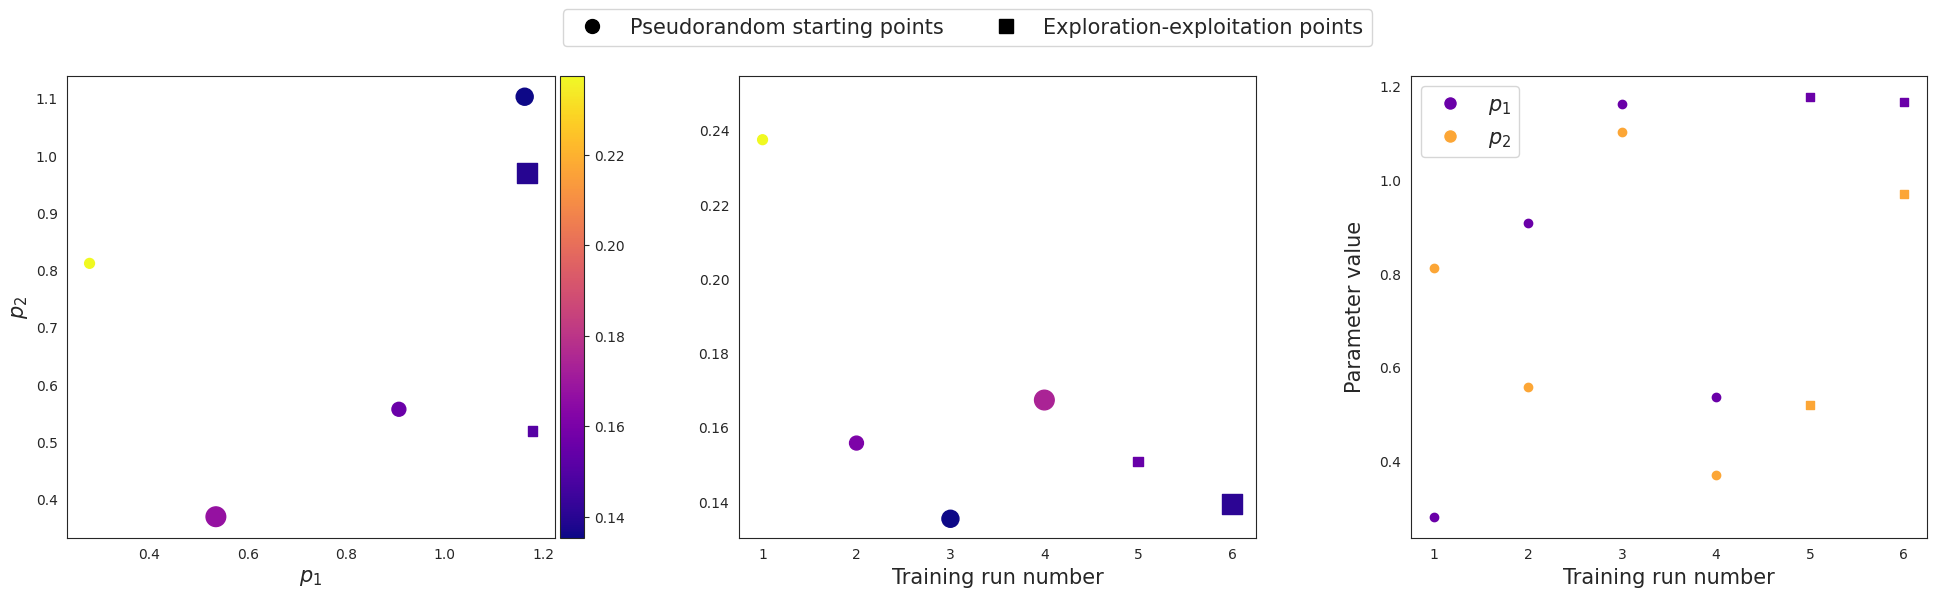

In [43]:
adann_opt(
    ADANN_base_model_class=ADANN_base_model_class,
    base_model_kwargs=base_model_kwargs,
    diff_model_class=diff_model_class,
    diff_model_params=diff_model_params,
    list_base_nr_timesteps=list_base_nr_timesteps_opt,
    opt_params=opt_params,
    training_samples_generator=training_samples_generator,
    optimizer_class=optimizer_class,
    loss_fn=loss_fn,
    base_training_kwargs=base_training_kwargs,
    base_lr_search_parameters=base_lr_search_parameters,
    diff_training_kwargs=diff_training_kwargs,
    diff_lr_search_parameters=diff_lr_search_parameters,
    output_folder_dir=output_folder_dir,
    methods=methods,
    methods_data=methods_data,
    test_input_values_rough=test_initial_values_rough,
    test_ref_sol_rough=test_ref_sol_rough,
    validation_input_values_rough=validation_initial_values_rough,
    validation_ref_sol_rough=validation_ref_sol_rough,
    pde_name=pde_name,
    space_size=space_size,
    dim=dim,
    only_train_base=only_train_base,
    local_learning_rates=local_learning_rates
)

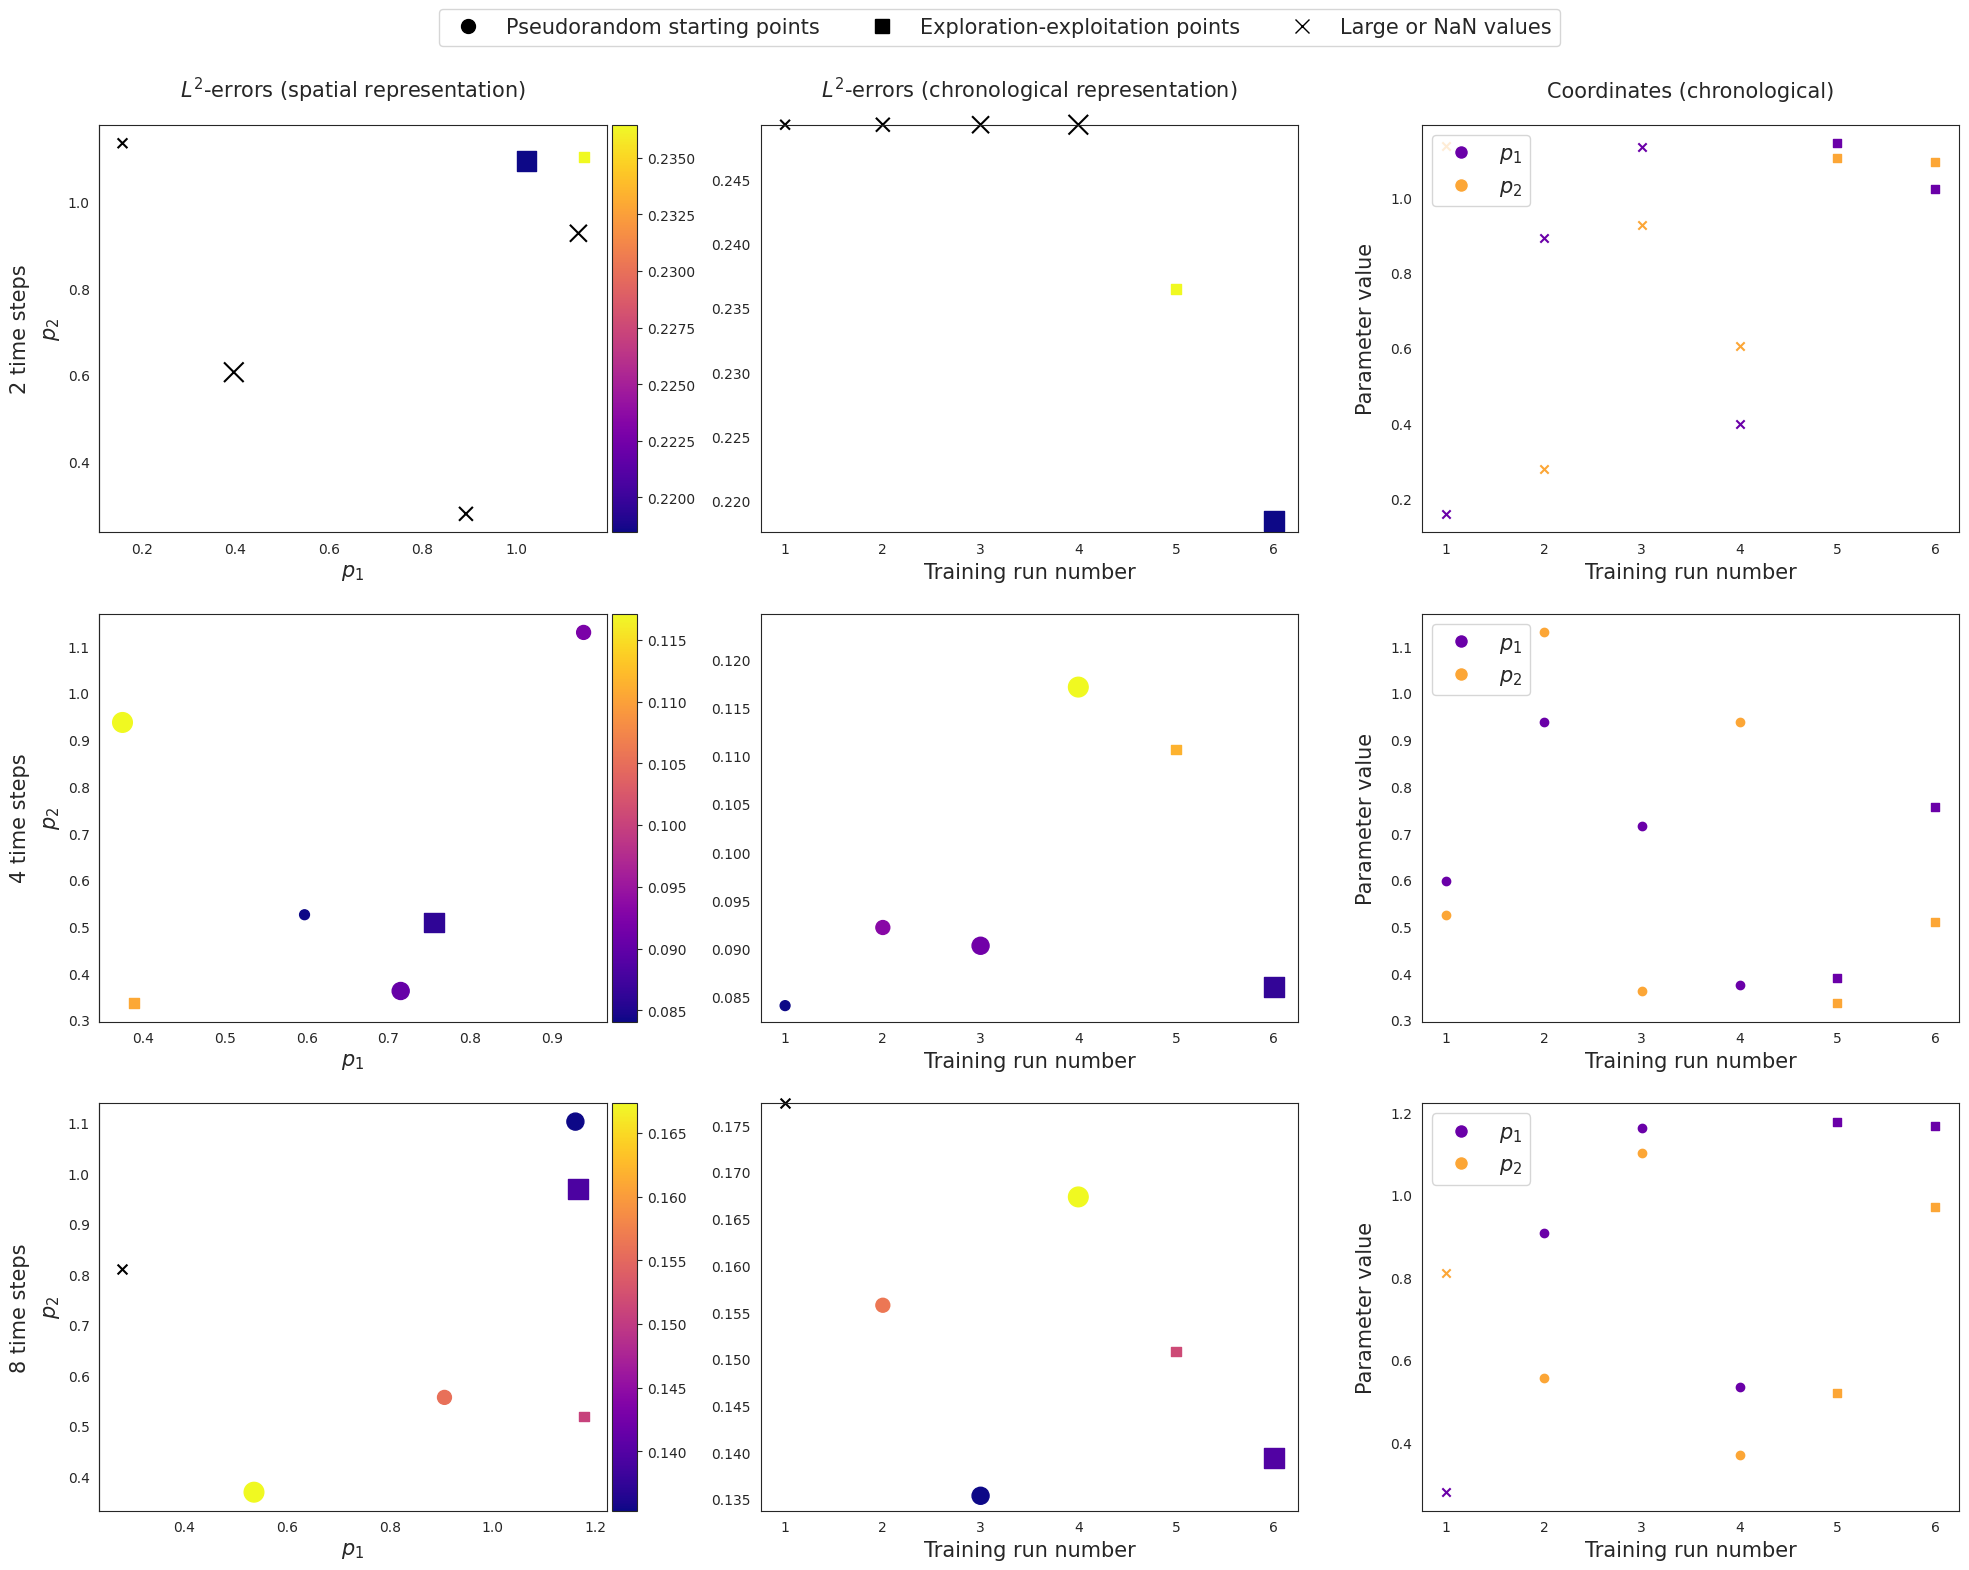

In [44]:
plot_opt_results_combined(output_folder_dir, pde_name=pde_name, list_base_nr_timesteps=list_base_nr_timesteps_opt, only_train_base=only_train_base, n_random_starts=opt_params[-1], cutoff=0.2)

### Standard operator learning models

In [45]:
# Overall training parameters
OL_training_kwargs = {
    "max_trainsteps": 1 if test_run else 100000,
    "initial_batchsize": base_training_kwargs["initial_batchsize"],
    "max_batchsize": base_training_kwargs["initial_batchsize"],
    "output_steps": 20 if test_run else base_training_kwargs["output_steps"],
    "eval_steps": 10 if test_run else base_training_kwargs["eval_steps"],
    "improvement_tolerance": 0.8 if test_run else base_training_kwargs["improvement_tolerance"],
    "initial_lr": None if test_run else None
}
nr_runs = 1 if test_run else n_calls

# learning rates
local_learning_rates=True
lr_test_trainsteps = 1 if test_run else base_lr_test_trainsteps
smallest_power = -20
largest_power = 5.
maxiter = 1 if test_run else 15
OL_lr_search_parameters = [lr_test_trainsteps, smallest_power, largest_power, maxiter]

In [46]:
#ANN models
ann_foldername = output_folder_dir + "Results_ANN"

input_dim = nr_spacediscr**dim

#ANN Parameters
list_ann_params = [
    [[input_dim, 2**9, 2**9, input_dim]] if dim==1 else [[input_dim, 2**11, 2**11, input_dim]],
    [[input_dim, 2**9, 2**11, 2**9, input_dim]] if dim==1 else [[input_dim, 2**11, 2**12, 2**11, input_dim]],
    [[input_dim, 2**9, 2**11, 2**13, 2**11, 2**9,  input_dim]] if dim==1 else [[input_dim, 2**11, 2**12, 2**13, 2**12, 2**11, input_dim]]
]

create_and_train_models(
    modelclass = ANNModel, 
    list_params = list_ann_params,
    training_samples_generator = training_samples_generator,
    optimizer_class = optimizer_class,
    loss_fn = loss_fn,
    training_kwargs=OL_training_kwargs,
    lr_search_params=OL_lr_search_parameters,
    nr_runs = nr_runs,
    methods = methods,
    methods_data = methods_data,
    foldername = ann_foldername,
    test_input_values = test_initial_values_rough,
    test_ref_sol = test_ref_sol_rough,
    validation_input_values = validation_initial_values_rough,
    validation_ref_sol = validation_ref_sol_rough,
    pde_name = pde_name,
    local_learning_rates=local_learning_rates
)





--------------------------------------RUN 0 for ANN (arch.: (16, 512, 512, 16)) --------------------------------------
------ SEARCHING OPTIMAL LEARNING RATE FOR ANN (arch.: (16, 512, 512, 16))_nr_0 ------
Evaluating at -0.9016994374947425
Best learning rate for ANN (arch.: (16, 512, 512, 16))_nr_0: 0.0018818072639922873
    Initial batch size:  256
    Initial learning rate:  0.0018818072639922873
0 (validation loss) : 1.47501624
0 (train loss) : 1.58988297

 -------------------------------------------
    Last loss:  1.5898829698562622
    Train time:  0.9955812330008484

 -------------------------------------------
 We have a new best model!
--------------------------------------
Best test model (nr. 0): 0.8541707333413677
Best validation model (nr. 0): 0.8493896200172318

Train times:
    Total time : 1.548071046010591
    Total train time: 0.9955812330008484
    Average train time: 0.9955812330008484
--------------------------------------



-----------------------------------

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [47]:
# FNO models
fno_foldername = output_folder_dir + "Results_FNO"

#list is [#modes, width, depth, dim]
list_fno_params = [
    [8, 20, 3, dim],
    [16, 30, 4, dim],
    [16 if test_run else 32, 40, 5, dim]
]

create_and_train_models(
    modelclass = FNOnDModel, 
    list_params = list_fno_params,
    training_samples_generator = training_samples_generator,
    optimizer_class = optimizer_class,
    loss_fn = loss_fn,
    training_kwargs=OL_training_kwargs,
    lr_search_params=OL_lr_search_parameters,
    nr_runs = nr_runs,
    methods = methods,
    methods_data = methods_data,
    foldername = fno_foldername,
    test_input_values = test_initial_values_rough,
    test_ref_sol = test_ref_sol_rough,
    validation_input_values = validation_initial_values_rough,
    validation_ref_sol = validation_ref_sol_rough,
    pde_name = pde_name,
    local_learning_rates=local_learning_rates
)





--------------------------------------RUN 0 for FNO (nr. modes: 8, width: 20, depth: 3) --------------------------------------
------ SEARCHING OPTIMAL LEARNING RATE FOR FNO (nr. modes: 8, width: 20, depth: 3)_nr_0 ------
Evaluating at -0.9016994374947425
Best learning rate for FNO (nr. modes: 8, width: 20, depth: 3)_nr_0: 0.0018818072639922873
    Initial batch size:  256
    Initial learning rate:  0.0018818072639922873
0 (validation loss) : 1.48752999
0 (train loss) : 1.43036127

 -------------------------------------------
    Last loss:  1.430361270904541
    Train time:  1.8564848710084334

 -------------------------------------------
 We have a new best model!
--------------------------------------
Best test model (nr. 0): 1.1930599555004866
Best validation model (nr. 0): 1.1821054096242394

Train times:
    Total time : 2.6209989040216897
    Total train time: 1.8564848710084334
    Average train time: 1.8564848710084334
--------------------------------------



-----------

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

### Classical Methods

In [48]:
 # Discretization parameters
nr_timesteps_fdm = list_base_nr_timesteps_opt

#Create all methods for the correponding timesteps
for nr_timesteps in nr_timesteps_fdm:
    name = f"FDM ({nr_timesteps} Crank-Nicolson time steps)"
    methods[name] = SecondOrderLirkFDMPeriodicSemilinearPDEAdannBasemodel(T, laplace_factor, nonlin, space_size, nr_spacediscr, nr_timesteps, nonlin_name=nonlin_name, dim=dim, scale=True).to(device)
    methods_data.at[name, "training_time"] = 0

# Evaluation

In [9]:
# Evaluate all the methods and create plots
nr_of_eval_runs = 2 if test_run else 1000
plot_histogram = False if test_run else True

method_categories = (["ANN", "FNO", "FDM"] +
                     (["ADANN base - grid"] if only_train_base else ["ADANN base - grid", "ADANN full - grid"]) +
                     (["ADANN base - EE"] if only_train_base else ["ADANN full - EE"])
                     )

space_grid = x_values(nr_spacediscr, space_size, dim=dim)

evaluate_and_plot(methods, 
                  methods_data, 
                  method_categories, 
                  validation_initial_values_rough, 
                  validation_ref_sol_rough, 
                  space_grid, 
                  space_size, 
                  output_folder_dir, 
                  pde_name, 
                  dim=dim, 
                  nr_of_eval_runs=nr_of_eval_runs, 
                  plot_histogram=plot_histogram,
                  legend_loc=None,
                  nr_of_plots= 1 if test_run else 5
                  )

#Save all the data in an Excel sheet
local_vars = locals()
params_dict = {k: [v] for k, v in local_vars.items() if isinstance(v, (int, str, float)) and k[0] != '_'}
save_excel_sheet(methods_data, params_dict, output_folder_dir + f'Results_{pde_name}.xlsx')

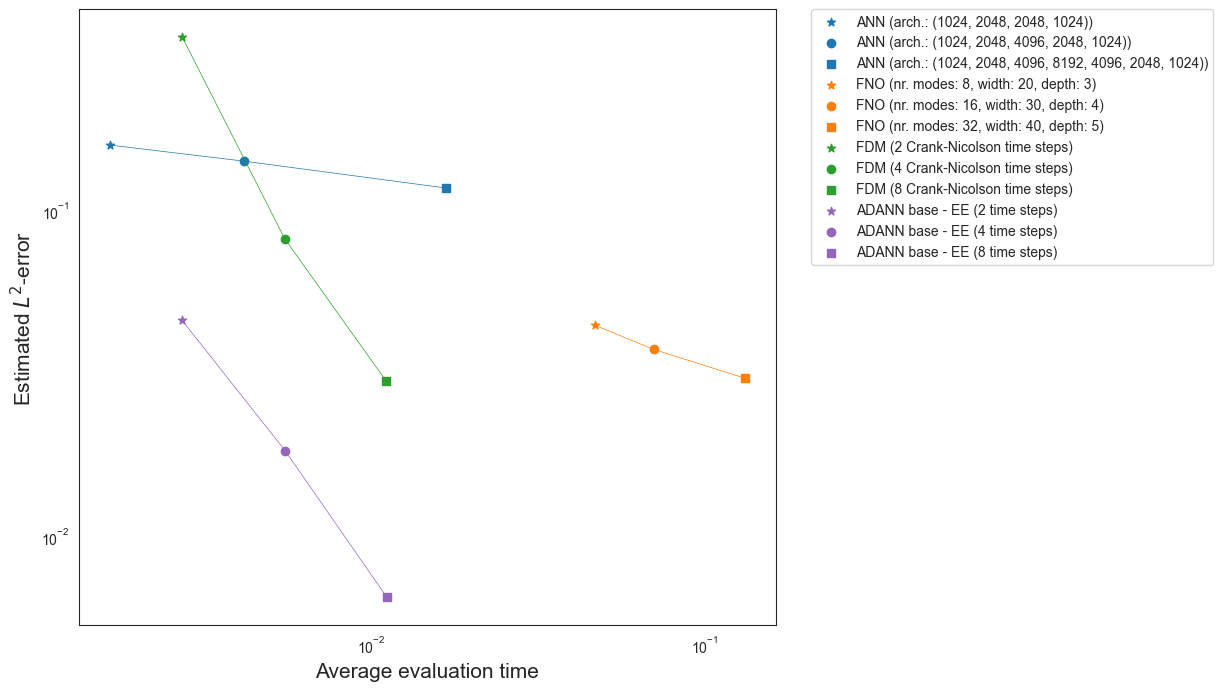

In [16]:
create_error_vs_comptime_plot(method_categories, output_folder_dir, pde_name)

### Testing zone